# Create WecOptTool Model for the Marson WEC concept

In [67]:
import autograd.numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute, Bounds
import pygmsh
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

### Waves and Frequency array

In [68]:
wavefreq = 1/7.4371 # Hz
f1 = wavefreq
nfreq = 2

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
print(freq)

amplitude = 0.5/2 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

[0.13446101 0.26892203]


#### WEC geometry mesh
Now we will create a surface mesh for the WEC hull and store it using the `FloatingBody` object from Capytaine.

INFO:capytaine.io.meshio:Stored 2766 triangle faces as quadrilaterals
c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\capytaine\meshes\meshes.py:759: RuntimeWarning: invalid value encountered in arctanh
  z_lid_comp = -np.arctanh(np.pi*g*p/omega_max**2) / (np.pi * p)


0.0


INFO:capytaine.io.meshio:Stored 2766 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_131"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={}, center_of_mass=[-5.  0.  0.], name="rect0").
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:The rotation dof Pitch has been initialized around the point: FloatingBody(..., name="rect0").rotation_center = (-5.0, 0, 0)
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_131 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:Ne

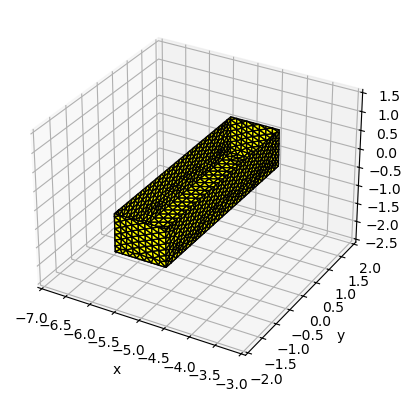

In [69]:
numBodies = 1
bodyDist = 10
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] #, 3]
mesh_size_factor = 0.16
depth = 2
bodDraft = [1, 1]#, 1]
bodWidth = [1, 1]#, 1]
bodLength = [2, 2]#, 2]

hydrostaticsDict = {}
rect = {}
bodList = []

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, depth-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-depth])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lid_pos = meshObj.lowest_lid_position(f1*nfreq*2*np.pi)
        print(lid_pos)
        lid_pos = -.05
        lidMesh = meshObj.generate_lid(z=lid_pos)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name="rect"+str(nBod), center_of_mass=(bodyLocs[nBod], 0, 0))
        rect[nBod].keep_immersed_part()

        rect[nBod].center_of_mass = (bodyLocs[nBod], 0, 0)
        rect[nBod].rotation_center = rect[nBod].center_of_mass
        rect[nBod].add_translation_dof(name="Heave")
        rect[nBod].add_rotation_dof(name="Pitch")
        #rect[nBod].add_translation_dof(name="Surge")

        rect[nBod].inertia_matrix = rect[nBod].compute_rigid_body_inertia(rho=1025)
        rect[nBod].hydrostatic_stiffness = rect[nBod].immersed_part().compute_hydrostatic_stiffness(rho=1025)

        #print(rect[nBod].inertia_matrix)
        #print(rect[nBod].hydrostatic_stiffness)

        bodList.append(rect[nBod])

all_bodies = cpt.FloatingBody.join_bodies(*bodList)

#allBodies.show_matplotlib()
all_bodies.show_matplotlib()
ndof = all_bodies.nb_dofs

#all_bodies.show()

#print(all_bodies.hydrostatic_stiffness)
#print(all_bodies.inertia_matrix)

In [70]:
print(dir(all_bodies))
print(all_bodies.center_of_mass)
print(all_bodies.inertia_matrix)
print(all_bodies.hydrostatic_stiffness)
#all_bodies.show()

['__abstractmethods__', '__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rich_repr__', '__setattr__', '__short_str__', '__sizeof__', '__slotnames__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_infer_rotation_center', '_optional_params_str', '_repr_pretty_', 'add_all_rigid_body_dofs', 'add_dofs_labels_to_matrix', 'add_dofs_labels_to_vector', 'add_rotation_dof', 'add_translation_dof', 'animate', 'assemble_arbitrary_array', 'assemble_regular_array', 'center_of_buoyancy', 'center_of_mass', 'clip', 'clipped', 'cluster_bodies', 'combine_dofs', 'compute_hydrostatic_stiffness', 'compute_hydrostatics', 'compute_rigid_body_inertia', 'copy', 'disp_mass', 'dof_normals', 'dofs', 'each_hydrostatic_stiffness', 'extract_faces

#### Minimum wavelength check
With the frequency vector, wave environment, and geometry mesh all defined, we can now check to make sure they are all suitable to accurately simulate the WEC dynamics.
The `fb.minimal_computable_wavelength` method checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine.
We compare this value to the minimum wavelength our frequency vector will compute; we want this number to be <u>larger</u> than Capytaine's minimum wavelength.
A warning is printed if this is not the case.
This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [71]:
#min_computable_wavelength = all_bodies.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

#if min_wavelength < min_computable_wavelength:
#    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
#         f' than the minimum computable wavelength ({min_computable_wavelength}).')

In [72]:
bem_data = wot.run_bem(all_bodies, freq, wave_dirs=0)
# wot.write_netcdf('bem_data.nc', bem_data) # saves BEM data to file


INFO:capytaine.green_functions.delhommeau:Loading tabulation from C:\Users\jtgrasb\AppData\Local\capytaine\Cache\2.2\tabulation_float64_scaled_nemoh3_676_100.0_372_-251.0_1001.npz
INFO:capytaine.bodies.bodies:Clipping rect0_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_131 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.


[13:40:34] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0_immersed"), omega=0.845, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=0.845, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=0.845, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="rect0_immersed"), omega=1.690, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=1.690, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="rect0_immersed"), omega=1.690, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0)

In [73]:
print(bem_data['inertia_matrix'])

<xarray.DataArray 'inertia_matrix' (influenced_dof: 2, radiating_dof: 2)> Size: 32B
array([[4100.        ,   -0.        ],
       [  -0.        , 1703.21199522]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 16B 'rect0__Heave' 'rect0__Pitch'
  * influenced_dof  (influenced_dof) object 16B 'rect0__Heave' 'rect0__Pitch'


In [74]:
nstate_pto = 2 * nfreq # PTO forces
nstate_opt = nstate_pto
pto_ndof = 1

In [75]:
# PTO is simply based on the pitch of the float (assuming pitch is constrained about PTO location)
name = ["PTO_1"]
kinematics = np.array([[1]])
inv_kinematics = np.array([[1]])

controller = wot.pto.controller_p
loss = None

## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 0.0
drivetrain_friction = 0.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia +
                        drivetrain_friction +
                        1/(1j*omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*omega*winding_inductance

pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

pto = wot.pto.PTO(pto_ndof, kinematics, controller, pto_impedance, loss, name[0], inv_kinematics=inv_kinematics)

In [76]:
print(abs(bem_data['excitation_force']))

<xarray.DataArray 'excitation_force' (omega: 2, wave_direction: 1,
                                      influenced_dof: 2)> Size: 32B
array([[[35316.55446644,  3155.59574832]],

       [[24250.69369611, 12898.55399541]]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * wave_direction  (wave_direction) float64 8B 0.0
  * omega           (omega) float64 16B 0.8448 1.69
  * influenced_dof  (influenced_dof) object 16B 'rect0__Heave' 'rect0__Pitch'
    period          (omega) float64 16B 7.437 3.719


In [77]:
hydro_data = wot.add_linear_friction(bem_data, None)
inertia_matrix = hydro_data['inertia_matrix'].values

#hydro_data['hydrostatic_stiffness'][0,1] = hydro_data['hydrostatic_stiffness'][0,0]*bodyDist/2 + hydro_data['hydrostatic_stiffness'][0,1]
#hydro_data['friction'][0,1] = hydro_data['friction'][0,0]*bodyDist/2 + hydro_data['friction'][0,1]
#hydro_data['added_mass'][:,0,1] = hydro_data['added_mass'][:,0,0]*bodyDist/2 + hydro_data['added_mass'][:,0,1]
#hydro_data['radiation_damping'][:,0,1] = hydro_data['radiation_damping'][:,0,0]*bodyDist/2 + hydro_data['radiation_damping'][:,0,1]
#hydro_data['hydrostatic_stiffness'][1,0] = hydro_data['hydrostatic_stiffness'][0,0]*bodyDist/2 + hydro_data['hydrostatic_stiffness'][1,0]
#hydro_data['friction'][1,0] = hydro_data['friction'][0,0]*bodyDist/2 + hydro_data['friction'][1,0]
#hydro_data['added_mass'][:,1,0] = hydro_data['added_mass'][:,0,0]*bodyDist/2 + hydro_data['added_mass'][:,1,0]
#hydro_data['radiation_damping'][:,1,0] = hydro_data['radiation_damping'][:,0,0]*bodyDist/2 + hydro_data['radiation_damping'][:,1,0]
#hydro_data['hydrostatic_stiffness'][1,1] = hydro_data['hydrostatic_stiffness'][0,0]*(bodyDist/2)**2 + hydro_data['hydrostatic_stiffness'][1,1]
#hydro_data['friction'][1,1] = hydro_data['friction'][0,0]*(bodyDist/2)**2 + hydro_data['friction'][1,1]
#hydro_data['added_mass'][:,1,1] = hydro_data['added_mass'][:,0,0]*(bodyDist/2)**2 + hydro_data['added_mass'][:,1,1]
#hydro_data['radiation_damping'][:,1,1] = hydro_data['radiation_damping'][:,0,0]*(bodyDist/2)**2 + hydro_data['radiation_damping'][:,1,1]

# frequency array
f1, nfreq = wot.frequency_parameters(hydro_data.omega.values/(2*np.pi), False)

# check real part of damping diagonal > 0
hydro_data = wot.check_radiation_damping(hydro_data, 1e-6, False)

coeff_dict_heave = {}
coeff_dict_pitch = {}
coeff_dict = {}

# standard forces sets up the expected forces based on the BEM data
# intrinsic impedance
coeff_dict['A'] = hydro_data['added_mass'].sel(influenced_dof='rect0__Heave',radiating_dof='rect0__Heave')*(bodyDist/2)**2 + \
    hydro_data['added_mass'].sel(influenced_dof=['rect0__Pitch'],radiating_dof=['rect0__Pitch'])
print(coeff_dict['A'][0])
coeff_dict['B'] = hydro_data['radiation_damping'].sel(influenced_dof='rect0__Heave',radiating_dof='rect0__Heave')*(bodyDist/2)**2 + \
    hydro_data['radiation_damping'].sel(influenced_dof=['rect0__Pitch'],radiating_dof=['rect0__Pitch'])
coeff_dict['K'] = hydro_data['hydrostatic_stiffness'].sel(influenced_dof='rect0__Heave',radiating_dof='rect0__Heave')*(bodyDist/2)**2 + \
    hydro_data['hydrostatic_stiffness'].sel(influenced_dof=['rect0__Pitch'],radiating_dof=['rect0__Pitch'])
coeff_dict['Bf'] = hydro_data['friction'].sel(influenced_dof='rect0__Heave',radiating_dof='rect0__Heave')*(bodyDist/2)**2 + \
    hydro_data['friction'].sel(influenced_dof=['rect0__Pitch'],radiating_dof=['rect0__Pitch'])
#coeff_dict_heave['FK'] = hydro_data['Froude_Krylov_force'].sel(influenced_dof='rect0__Heave')
#coeff_dict_heave['diff'] = hydro_data['diffraction_force'].sel(influenced_dof='rect0__Heave')

# REPLACE with values from 1 dof pitch
#coeff_dict['A'][0] = 76684.33022237
#coeff_dict['A'][1] = 62062.86738381
#coeff_dict['B'][0] = 9760.48065797
#coeff_dict['B'][1] = 35601.06961661

coeff_dict['FK'] = hydro_data['Froude_Krylov_force'].sel(influenced_dof='rect0__Heave')*bodyDist/2 + hydro_data['Froude_Krylov_force'].sel(influenced_dof=['rect0__Pitch']) # since we're adding the heave force into pitch here, I think the force in heave is 0
coeff_dict['diff'] = hydro_data['diffraction_force'].sel(influenced_dof='rect0__Heave')*bodyDist/2 + hydro_data['diffraction_force'].sel(influenced_dof=['rect0__Pitch'])

def add_dof(coeff, dof_name):
    coeff = coeff.assign_coords(influenced_dof = dof_name)
    coeff = coeff.expand_dims(dim = {'influenced_dof':1}, axis=-1)
    return coeff

#for coeff in coeff_dict_heave:
#    coeff_dict_heave[coeff] = add_dof(coeff_dict_heave[coeff], 'rect0__Heave')

#for coeff in coeff_dict_pitch:
    #coeff_dict_pitch[coeff] = add_dof(coeff_dict_pitch[coeff], 'rect0__Pitch')

#for coeff in coeff_dict_heave:
#    coeff_dict[coeff] = coeff_dict_pitch[coeff]

coeff_dict['w'] = hydro_data['omega']

rao_transfer_functions = dict()
rao_transfer_functions['radiation'] = (1j*coeff_dict['w']*coeff_dict['B'] + -1*coeff_dict['w']**2*coeff_dict['A'], False)
rao_transfer_functions['friction'] = (1j*coeff_dict['w']*coeff_dict['Bf'], False)

# include zero_freq in hydrostatics
hs = ((coeff_dict['K'] + 0j).expand_dims({"omega": coeff_dict['B'].omega}, 0))
tmp = hs.isel(omega=0).copy(deep=True)
tmp['omega'] = tmp['omega'] * 0
hs = xr.concat([tmp, hs], dim='omega') #, data_vars='minimal')
rao_transfer_functions['hydrostatics'] = (hs, True)

linear_force_functions_about_PTO = dict()
for name, (value, zero_freq) in rao_transfer_functions.items():
    value = value.transpose("omega", "radiating_dof", "influenced_dof")
    value = -1*value  # RHS of equation: ma = Σf
    linear_force_functions_about_PTO[name] = (wot.force_from_rao_transfer_function(value, zero_freq))

# wave excitation
excitation_coefficients = {
    'Froude_Krylov': coeff_dict['FK'],
    'diffraction': coeff_dict['diff'],
}

for name, value in excitation_coefficients.items():
    linear_force_functions_about_PTO[name] = wot.force_from_waves(value)

coeff_dict['inertia'] = hydro_data['inertia_matrix'].sel(influenced_dof='rect0__Heave',radiating_dof='rect0__Heave')*(bodyDist/2)**2 + \
    hydro_data['inertia_matrix'].sel(influenced_dof=['rect0__Pitch'],radiating_dof=['rect0__Pitch'])

rao_transfer_function = - -1*coeff_dict['w']**2*coeff_dict['inertia'] + 0j # it is negative because it should be inertia forces - other forces
inertia_fun = wot.force_from_rao_transfer_function(rao_transfer_function, False)
linear_force_functions_about_PTO['inertia'] = inertia_fun

#print(bem_data['inertia_matrix'])

#omega = np.expand_dims(wot.frequency(f1, nfreq, False)*2*np.pi, [1,2])
#inertia_matrix = np.expand_dims(hydro_data['inertia_matrix'], 0)
#rao_transfer_function = -1*omega**2*inertia_matrix + 0j

#linear_force_functions_about_PTO['inertia'] = (wot.force_from_rao_transfer_function(rao_transfer_function, False))

print(linear_force_functions_about_PTO) # heave 

<xarray.DataArray 'added_mass' (radiating_dof: 1, influenced_dof: 1)> Size: 8B
array([[76690.49907784]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
    omega           float64 8B 0.8448
  * radiating_dof   (radiating_dof) object 8B 'rect0__Pitch'
  * influenced_dof  (influenced_dof) object 8B 'rect0__Pitch'
    period          float64 8B 7.437
{'radiation': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D65E40>, 'friction': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D67380>, 'hydrostatics': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D64220>, 'Froude_Krylov': <function force_from_waves.<locals>.force at 0x000001E304D659E0>, 'diffraction': <function force_from_waves.<locals>.force at 0x000001E304D645E0>, 'inertia': <function force_from_rao_tra

In [78]:
coeff_dict['K']

<xarray.DataArray 'hydrostatic_stiffness' (influenced_dof: 1, radiating_dof: 1)> Size: 8B
array([[988724.42617645]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 8B 'rect0__Pitch'
  * influenced_dof  (influenced_dof) object 8B 'rect0__Pitch'

In [79]:
print(bem_data['inertia_matrix'])
print(abs(coeff_dict['diff']))
print(abs(coeff_dict['FK']))
print(coeff_dict['inertia'])
print(coeff_dict['A'])
print(coeff_dict['B'])
print(coeff_dict['K'])

<xarray.DataArray 'inertia_matrix' (influenced_dof: 2, radiating_dof: 2)> Size: 32B
array([[4100.        ,   -0.        ],
       [  -0.        , 1703.21199522]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * radiating_dof   (radiating_dof) object 16B 'rect0__Heave' 'rect0__Pitch'
  * influenced_dof  (influenced_dof) object 16B 'rect0__Heave' 'rect0__Pitch'
<xarray.DataArray 'diffraction_force' (omega: 2, wave_direction: 1,
                                       influenced_dof: 1)> Size: 16B
array([[[10385.35514761]],

       [[30225.4135761 ]]])
Coordinates:
    g               float64 8B 9.81
    rho             float64 8B 1.025e+03
    body_name       <U14 56B 'rect0_immersed'
    water_depth     float64 8B inf
    forward_speed   float64 8B 0.0
  * wave_direction  (wave_direction) float64 8B 0.0
  * omega           (omeg

In [80]:

# PTO dynamics forcing function
f_add = {'PTO_1': pto.force_on_wec} | linear_force_functions_about_PTO

# Constraint
f_max = 20000
nsubsteps = 4
pto_max_pos = 30*np.pi/180

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

def const_heave(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    heave_theoretical = (bodyDist/2)*np.sin(x_wec[2*nfreq:])
    return (x_wec[:2*nfreq] - heave_theoretical).flatten()

def const_b2_pos(wec, x_wec, x_opt, waves): # surge of float 2 shouldn't have a mean of 0
    length_const = b2_pto_dist(wec, x_wec, x_opt, waves)
    return abs(0.5*bodyDist - length_const).flatten()

constraints = [
    {'type': 'ineq', 'fun': const_f_pto},
#    {'type': 'eq', 'fun': const_heave},
#    {'type': 'ineq', 'fun': const_b2_pos},
]

In [81]:
# create wec manually

# add friction
hydro_data = wot.add_linear_friction(bem_data, None)
inertia_matrix = coeff_dict['inertia'] # hydro_data['inertia_matrix'].values

# frequency array
f1, nfreq = wot.frequency_parameters(hydro_data.omega.values/(2*np.pi), False)

# check real part of damping diagonal > 0
hydro_data = wot.check_radiation_damping(hydro_data, 1e-6, False)

# forces in the dynamics equations
linear_force_functions = wot.standard_forces(hydro_data)
f_add = f_add if (f_add is not None) else {}
forces = linear_force_functions | f_add
# constraints
constraints = constraints if (constraints is not None) else []
wec = wot.WEC(f1, nfreq, forces, constraints, inertia_in_forces=True, ndof=1) # only pitch dof

#wec = wot.WEC.from_bem(
#    bem_data,
#    constraints=constraints,
#    friction=None,
#    f_add=f_add,
#)


In [82]:
print(f_add)

{'PTO_1': <bound method PTO.force_on_wec of <wecopttool.pto.PTO object at 0x000001E30621D0D0>>, 'radiation': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D65E40>, 'friction': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D67380>, 'hydrostatics': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D64220>, 'Froude_Krylov': <function force_from_waves.<locals>.force at 0x000001E304D659E0>, 'diffraction': <function force_from_waves.<locals>.force at 0x000001E304D645E0>, 'inertia': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D64FE0>}


In [83]:
    # realistic bounds for Kp
bounds = Bounds([0],[0])

obj_fun = pto.average_power
nstate_opt = 1

options = {'maxiter': 200}
scale_x_wec = 1e2
scale_x_opt = 1e-1
scale_obj = 1e1

results = wec.solve(
    waves, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    bounds_opt=bounds,
    )

opt_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_average_power} W')

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\wecopttool\core.py:759: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [3.92e+00, 0.00e+00, 0.00e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 2
            Gradient evaluations: 1
Optimal average mechanical power: 0.0 W


In [84]:
print(wec.dof_names)

['DOF_0']


[2.84217094e-16 3.31390170e-02 3.92275885e-02 2.84217094e-16]
[0.]


[13:40:37] WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an    
                    underscore are ignored when legend() is called with no argument.

([<matplotlib.axis.YTick at 0x1e3050d9750>,
 [Text(0, -20.0, '−20'),
  Text(0, -18.0, '−18'),
  Text(0, -16.0, '−16'),
  Text(0, -14.0, '−14'),
  Text(0, -12.0, '−12'),
  Text(0, -10.0, '−10'),
  Text(0, -8.0, '−8'),
  Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0')])

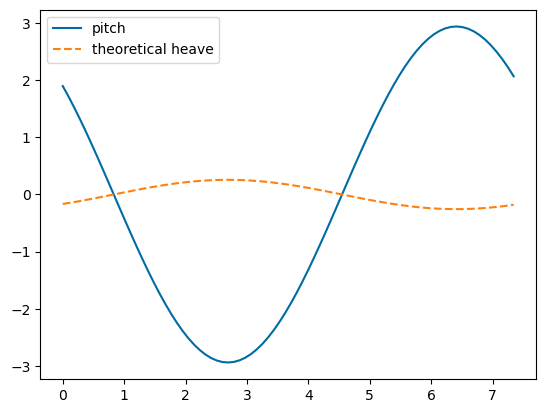

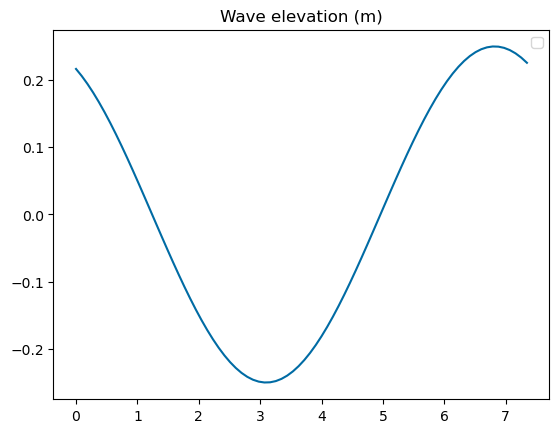

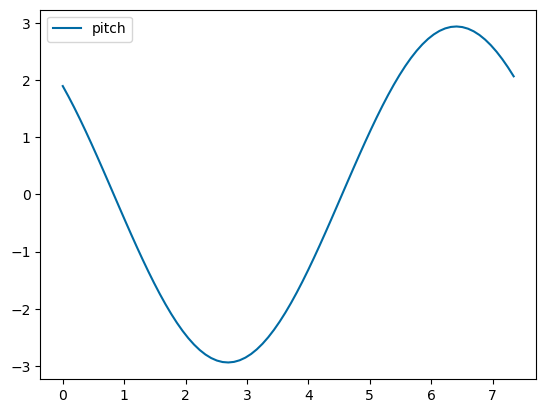

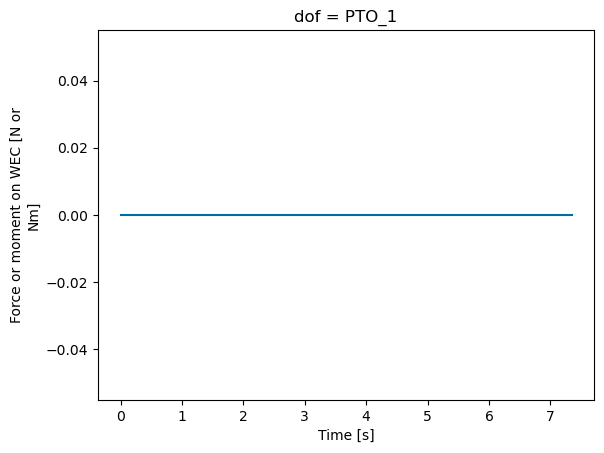

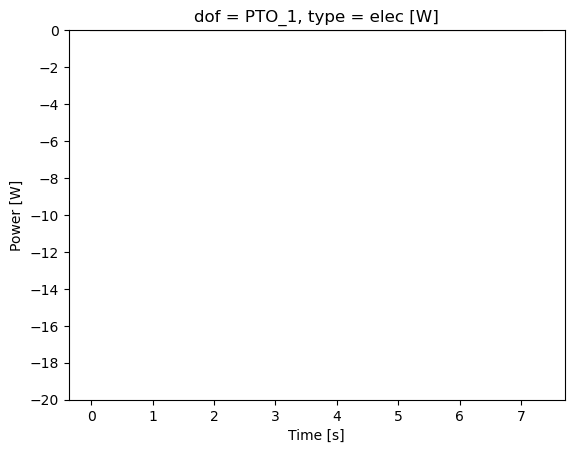

In [85]:
x_wec, x_opt = wec.decompose_state(results[0].x)
print(x_wec)
print(x_opt)

nsubsteps = 20
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)

# calculate theoretical heave
theoretical_heave = -(bodyDist/2)*np.sin(wec_tdom[0]['pos'])

plt.figure()
plt.plot(wec_tdom[0]['time'], wec_tdom[0]['pos'][0]*(180/np.pi), label='pitch')
#wec_tdom[0]['pos'][1].plot(label='pitch')
plt.plot(wec_tdom[0]['time'], np.squeeze(theoretical_heave),'--',label='theoretical heave')
plt.legend()

plt.figure()
#wec_tdom[0]['pos'].plot(label='heave')
plt.plot(wec_tdom[0]['time'],np.squeeze(wec_tdom[0]['wave_elev']))
plt.title('Wave elevation (m)')
plt.legend()

plt.figure()
#wec_tdom[0]['pos'].plot(label='heave')
plt.plot(wec_tdom[0]['time'],np.squeeze(wec_tdom[0]['pos']*180/np.pi),label='pitch')
plt.legend()

plt.figure()
pto_tdom[0]['force'].plot()

plt.figure()
pto_tdom[0]['power'].loc['mech',:,:].plot()
pto_tdom[0]['power'].loc['elec',:,:].plot()
plt.ylim([-20, 0])
plt.yticks(np.linspace(-20,0,11))


In [86]:
# check residual
resid_dof = 0

print(wec.forces)
if not wec.inertia_in_forces:
    ri = wec.inertia(wec, x_wec, x_opt, waves)[:,resid_dof]
else:
    ri = np.zeros([wec.ncomponents, wec.ndof])
# forces, -Σf
for f in wec.forces.values():
    ri = ri - f(wec, x_wec, x_opt, waves.sel(realization=0))#[:,resid_dof]
    
#print(wec.dofmat_to_vec(ri))

{'radiation': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D65E40>, 'friction': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D67380>, 'hydrostatics': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D64220>, 'Froude_Krylov': <function force_from_waves.<locals>.force at 0x000001E304D659E0>, 'diffraction': <function force_from_waves.<locals>.force at 0x000001E304D645E0>, 'PTO_1': <bound method PTO.force_on_wec of <wecopttool.pto.PTO object at 0x000001E30621D0D0>>, 'inertia': <function force_from_rao_transfer_function.<locals>.force at 0x000001E304D64FE0>}


In [87]:
# examine the kinematics matrix and how PTO force is calculated on the WEC

force_td = pto.force(wec, x_wec, x_opt, waves, nsubsteps=nsubsteps)
force_td = np.expand_dims(np.transpose(force_td), axis=0)
kinematics_mat = pto.kinematics(wec, x_wec, x_opt, waves, nsubsteps)
print(kinematics_mat)
kinematics_mat = np.transpose(kinematics_mat, (1,0,2))
print(kinematics_mat)
force_on_wec = np.transpose(np.sum(kinematics_mat*force_td, axis=1))
print(force_on_wec)

[[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
   1 1 1 1 1 1 1 1 1 1]]]
[[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
   1 1 1 1 1 1 1 1 1 1]]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


<xarray.DataArray 'type' (type: 7)> Size: 56B
array(['radiation', 'friction', 'hydrostatics', 'Froude_Krylov', 'diffraction',
       'PTO_1', 'inertia'], dtype=object)
Coordinates:
    realization  int32 4B 0
    omega        float64 8B 1.69
    freq         float64 8B 0.2689
    period       float64 8B 3.719
  * type         (type) object 56B 'radiation' 'friction' ... 'PTO_1' 'inertia'
Attributes:
    long_name:  Type


Text(0, 0.5, 'pitch hydrostatics')

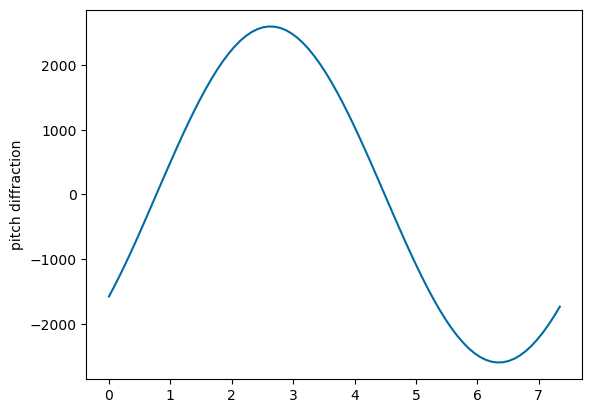

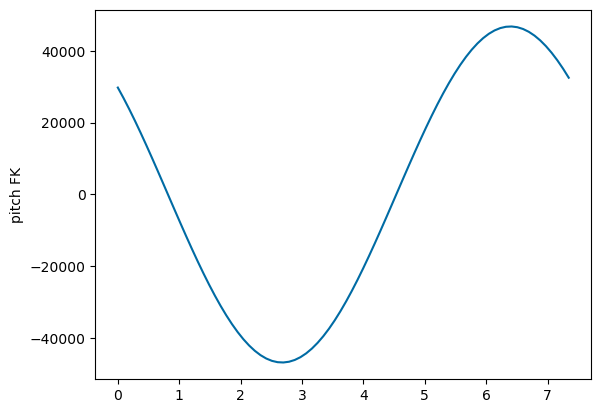

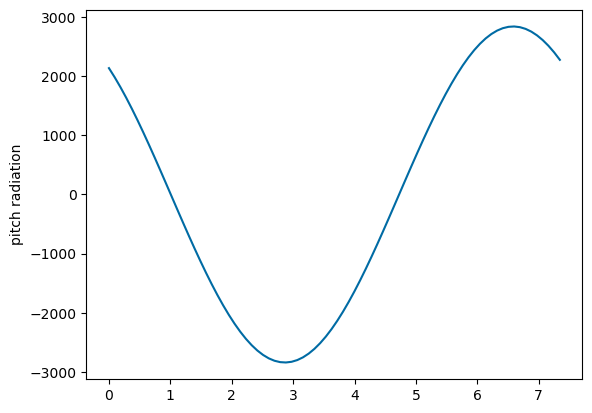

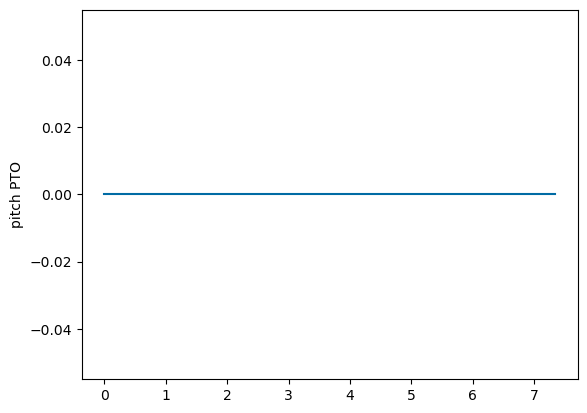

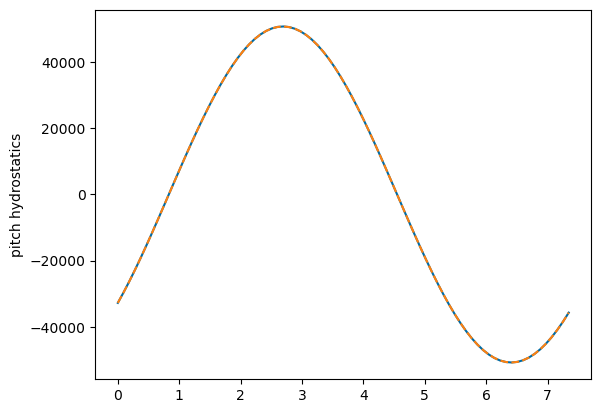

In [88]:
hs_theoretical1 = -coeff_dict['K'].sel(influenced_dof='rect0__Pitch',radiating_dof='rect0__Pitch')*wec_tdom[0]['pos']

print(wec_tdom[0]['force']['type'])

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'].sel(type='diffraction')))
plt.ylabel('pitch diffraction')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'].sel(type='Froude_Krylov')))
plt.ylabel('pitch FK')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'].sel(type='radiation')))
plt.ylabel('pitch radiation')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'].sel(type='PTO_1')))
plt.ylabel('pitch PTO')

plt.figure()
plt.plot(wec_tdom[0]['time'], np.squeeze(wec_tdom[0]['force'].sel(type='hydrostatics')))
plt.plot(wec_tdom[0]['time'], np.squeeze(hs_theoretical1),'--')
plt.ylabel('pitch hydrostatics')